In [141]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import FlagserPersistence
from gtda.diagrams import BettiCurve
import matplotlib.pyplot as plt
import gudhi as gd
from gtda.plotting import plot_diagram
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [142]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file, strict=False)
        
    return game_data

def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    counts = [pass_info["count"] for player in game for pass_info in player["passes"]]
    max_count = max(counts)
    min_count = min(counts)

    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))

    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]

            edge_weight = 1 - (count - min_count) / (max_count - min_count)


            G.add_edge(player1, player2, weight=edge_weight)

    return G

def compute_persistence_stats(diagrams):
    diagrams = np.array(diagrams)
    
    h0_data = diagrams[diagrams[:, 2] == 0]
    h1_data = diagrams[diagrams[:, 2] == 1]
    
    persistence_h0 = h0_data[:, 1] - h0_data[:, 0]
    persistence_h1 = h1_data[:, 1] - h1_data[:, 0]

    persistence_h0 = np.where(persistence_h0 == np.inf, 1, persistence_h0)
    persistence_h1 = np.where(persistence_h1 == np.inf, 1, persistence_h1)
    
    avg_h0 = np.mean(persistence_h0) if len(persistence_h0) > 0 else 0
    std_h0 = np.std(persistence_h0) if len(persistence_h0) > 0 else 0
    avg_h1 = np.mean(persistence_h1) if len(persistence_h1) > 0 else 0
    std_h1 = np.std(persistence_h1) if len(persistence_h1) > 0 else 0
    
    return {
        "Average H0": avg_h0,
        "Std H0": std_h0,
        "Average H1": avg_h1,
        "Std H1": std_h1
    }



def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes


In [143]:
directory_path = '../data/2015-2016/1-Bundesliga/*.json'
# directory_path = '../data/2015-2016/Premier-League/*.json'
# directory_path = '../data/2015-2016/Serie-A/*.json'
# directory_path = '../data/2015-2016/La-Liga/*.json'


persistence_stats = {}

for file_path in glob.glob(directory_path):
    filename = os.path.basename(file_path)
    filename_list = filename.split('_')
    team = filename_list[1]
    goals = int(filename_list[-2])
    minutes = int(filename_list[-1].split('.')[0])

    goal_per_90 = goals / (minutes / 90)

    current_game = load_game_data(file_path)
    G_example = construct_adjacency_matrix(current_game)
    adj_matrix, nodes = graph_to_adjacency_matrix(G_example)

    fp = FlagserPersistence()
    diagrams = fp.fit_transform([adj_matrix])[0]  # Persistence diagram

    # Compute persistence stats
    stats = compute_persistence_stats(diagrams)
    stats["Goals per 90"] = goal_per_90

    # Aggregate stats by team
    if team not in persistence_stats:
        persistence_stats[team] = []
    persistence_stats[team].append(stats)

Amount of teams: 18


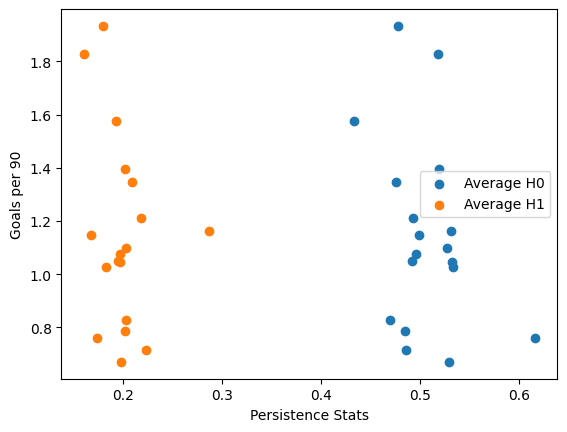

Correlation between Average H0 and Goals per 90: -0.33384362504679654
Correlation between Average H1 and Goals per 90: -0.23290871105547653


In [144]:
team_stats = {}
print(f"Amount of teams: {len(persistence_stats)}")
for team, stats_list in persistence_stats.items():
    stats_df = pd.DataFrame(stats_list)
    team_stats[team] = stats_df.mean().to_dict()


team_stats_df = pd.DataFrame.from_dict(team_stats, orient='index')

plt.scatter(team_stats_df["Average H0"], team_stats_df["Goals per 90"], label="Average H0")
plt.scatter(team_stats_df["Average H1"], team_stats_df["Goals per 90"], label="Average H1")
plt.xlabel("Persistence Stats")
plt.ylabel("Goals per 90")
plt.legend()
plt.show()

correlation_avg_h0 = team_stats_df["Average H0"].corr(team_stats_df["Goals per 90"])
correlation_avg_h1 = team_stats_df["Average H1"].corr(team_stats_df["Goals per 90"])
print(f"Correlation between Average H0 and Goals per 90: {correlation_avg_h0}")
print(f"Correlation between Average H1 and Goals per 90: {correlation_avg_h1}")


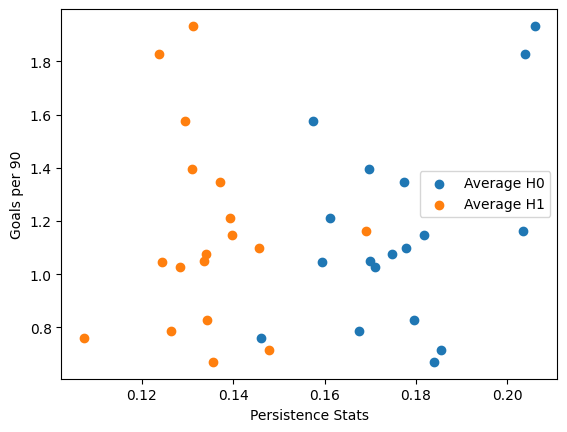

Correlation between Std H0 and Goals per 90: 0.4119815554705518
Correlation between Std H1 and Goals per 90: -0.03961243371163807


In [145]:
plt.scatter(team_stats_df["Std H0"], team_stats_df["Goals per 90"], label="Average H0")
plt.scatter(team_stats_df["Std H1"], team_stats_df["Goals per 90"], label="Average H1")
plt.xlabel("Persistence Stats")
plt.ylabel("Goals per 90")
plt.legend()
plt.show()

correlation_avg_h0 = team_stats_df["Std H0"].corr(team_stats_df["Goals per 90"])
correlation_avg_h1 = team_stats_df["Std H1"].corr(team_stats_df["Goals per 90"])
print(f"Correlation between Std H0 and Goals per 90: {correlation_avg_h0}")
print(f"Correlation between Std H1 and Goals per 90: {correlation_avg_h1}")

In [146]:
# Features and target
X = team_stats_df[["Average H0", "Std H0", "Average H1", "Std H1"]]
y = team_stats_df["Goals per 90"]

# Fit the regression model
model = LinearRegression()
model.fit(X, y)

# Predict and compute R^2
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print("R^2:", r2)

R^2: 0.3737489421788306


In [147]:
coefficients = model.coef_
intercept = model.intercept_

print(f"Goals per 90 = {coefficients[0]:.4f} * Average H0 + {coefficients[1]:.4f} * Std H0 + {coefficients[2]:.4f} * Average H1 + {coefficients[3]:.4f} * Std H1 + {intercept:.4f}")

Goals per 90 = -3.1336 * Average H0 + 12.4613 * Std H0 + -0.8240 * Average H1 + -11.0798 * Std H1 + 2.1885


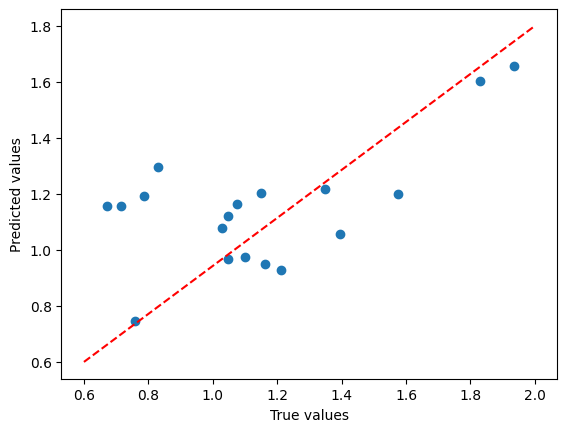

In [148]:
# plot the linear regression
plt.scatter(y, y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted values")

# dotted line
plt.plot([0.6, 2.0], [0.6, 1.8], color='red', linestyle='dashed')

plt.show()